In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from NEF_syn import *
from NEF_rec import *

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

# Debug

In [7]:
dataset='jiang'
sid=1
empirical = pd.read_pickle(f"data/{dataset}.pkl").query("sid==@sid")
trials = empirical['trial'].unique() 
alpha=0.2
z=0
lambd=0
n_neurons=500
W = np.zeros((1, n_neurons))
for trial in trials[:10]:
    print(f"training sid {sid}, trial {trial}")
    env = EnvironmentSyn(dataset, sid=sid, trial=trial)
    net, sim, W = simulate_NEF_rec(W, env, alpha=alpha, n_neurons=n_neurons, lambd=lambd, seed_net=sid, train=True)
env = EnvironmentSyn(dataset, sid=sid, trial=trials[-1])
net, sim = simulate_NEF_rec(W, env, alpha=alpha, n_neurons=n_neurons, lambd=lambd, seed_net=sid, train=False)

training sid 1, trial 1
training sid 1, trial 2
training sid 1, trial 3
training sid 1, trial 4
training sid 1, trial 5
training sid 1, trial 6
training sid 1, trial 7
training sid 1, trial 8
training sid 1, trial 9
training sid 1, trial 10


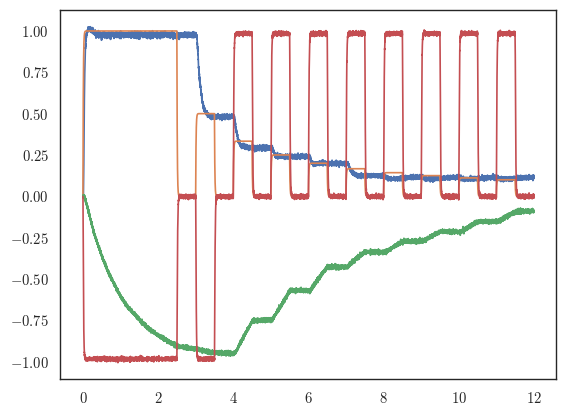

In [8]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[net.probe_weight])
ax.plot(sim.trange(), sim.data[net.probe_target])
ax.plot(sim.trange(), sim.data[net.probe_value])
ax.plot(sim.trange(), sim.data[net.probe_stim])
plt.show()

In [6]:
# fig, ax = plt.subplots()
# ax.plot(sim.trange(), sim.data[net.probe_context])
# plt.show()

# Decode value estimate during intertrial interval

In [2]:
syn = run_NEF_syn("carrabin", sid=1, alpha=5e-4, z=0, lambd=0, n_neurons=500, pretrain=True, iti=True)

training sid 1, trial 1
training sid 1, trial 2
training sid 1, trial 3
training sid 1, trial 4
training sid 1, trial 5
training sid 1, trial 6
training sid 1, trial 7
training sid 1, trial 8
training sid 1, trial 9
training sid 1, trial 10
training sid 1, trial 11
training sid 1, trial 12
training sid 1, trial 13
training sid 1, trial 14
training sid 1, trial 15
training sid 1, trial 16
training sid 1, trial 17
training sid 1, trial 18
training sid 1, trial 19
training sid 1, trial 20
running sid 1, trial 1
running sid 1, trial 2
running sid 1, trial 3
running sid 1, trial 4
running sid 1, trial 5
running sid 1, trial 6
running sid 1, trial 7
running sid 1, trial 8
running sid 1, trial 9
running sid 1, trial 10
running sid 1, trial 11
running sid 1, trial 12
running sid 1, trial 13
running sid 1, trial 14
running sid 1, trial 15
running sid 1, trial 16
running sid 1, trial 17
running sid 1, trial 18
running sid 1, trial 19
running sid 1, trial 20
running sid 1, trial 21
running sid 1,

In [7]:
syn.to_pickle("data/NEF_syn_compare_ITI.pkl")

In [4]:
rec = run_NEF_rec("carrabin", sid=1, alpha=0.2, z=0, lambd=0, n_neurons=500, pretrain=True, iti=True)

training sid 1, trial 1
training sid 1, trial 2
training sid 1, trial 3
training sid 1, trial 4
training sid 1, trial 5
training sid 1, trial 6
training sid 1, trial 7
training sid 1, trial 8
training sid 1, trial 9
training sid 1, trial 10
training sid 1, trial 11
training sid 1, trial 12
training sid 1, trial 13
training sid 1, trial 14
training sid 1, trial 15
training sid 1, trial 16
training sid 1, trial 17
training sid 1, trial 18
training sid 1, trial 19
training sid 1, trial 20
running sid 1, trial 1
running sid 1, trial 2
running sid 1, trial 3
running sid 1, trial 4
running sid 1, trial 5
running sid 1, trial 6
running sid 1, trial 7
running sid 1, trial 8
running sid 1, trial 9
running sid 1, trial 10
running sid 1, trial 11
running sid 1, trial 12
running sid 1, trial 13
running sid 1, trial 14
running sid 1, trial 15
running sid 1, trial 16
running sid 1, trial 17
running sid 1, trial 18
running sid 1, trial 19
running sid 1, trial 20
running sid 1, trial 21
running sid 1,

In [6]:
rec.to_pickle("data/NEF_rec_compare_ITI.pkl")

## Compare with human responses (QID mean loss)

In [8]:
sid = 1
syn = pd.read_pickle("data/NEF_syn_compare_ITI.pkl")
rec = pd.read_pickle("data/NEF_rec_compare_ITI.pkl")
human = pd.read_pickle("data/carrabin.pkl").query("sid==@sid")
trials = human['trial'].unique()
stages = human['stage'].unique()
dfs = []
columns = ['type', 'qid', 'response']
for model_type in ['NEF_syn', 'NEF_rec']:
    nef = syn if model_type=='NEF_syn' else rec
    for trial in trials:
        for stage in stages:
            qid = human.query("trial==@trial and stage==@stage")['qid'].unique()[0]
            response_human = human.query("trial==@trial and stage==@stage")['response'].unique()[0]
            dfs.append(pd.DataFrame([["human", qid, response_human]], columns=columns))
            response_model = nef.query("trial==@trial & stage==@stage")['estimate'].unique()[0]
            dfs.append(pd.DataFrame([[model_type, qid, response_model]], columns=columns))
response_data = pd.concat(dfs, ignore_index=True)
columns = ['type', 'qid', 'mean error']
dfs = []
for model_type in ['NEF_syn', 'NEF_rec']:
    for qid in response_data['qid'].unique():
        n_total = response_data.query("type=='human'")['qid'].size
        n_qid = response_data.query("type=='human' & qid==@qid")['qid'].size
        W = n_qid / n_total
        responses_model = response_data.query("qid==@qid & type==@model_type")['response'].to_numpy()
        responses_human = response_data.query("qid==@qid & type=='human'")['response'].to_numpy()
        error = W * np.abs(np.mean(responses_model) - np.mean(responses_human))
        dfs.append(pd.DataFrame([[model_type, qid, error]], columns=columns))
error_data = pd.concat(dfs, ignore_index=True)

In [9]:
# error_data

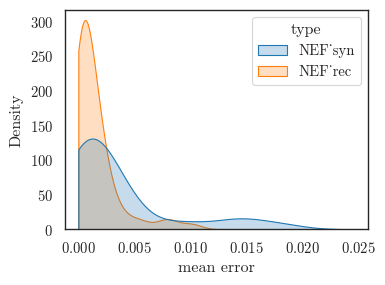

In [15]:
fig, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(error_data, x='mean error', hue='type', ax=ax, fill=True, common_norm=False, palette=palette[:2], clip=[0,1])
plt.tight_layout()
plt.show()

In [16]:
rec

,type,sid,trial,stage,estimate
0,NEF_rec,1,1,1,0.139767
1,NEF_rec,1,1,2,0.011230
2,NEF_rec,1,1,3,-0.074065
3,NEF_rec,1,1,4,-0.140867
4,NEF_rec,1,1,5,-0.200068
...,...,...,...,...,...
995,NEF_rec,1,200,1,0.139767
996,NEF_rec,1,200,2,0.233208
997,NEF_rec,1,200,3,0.295902
998,NEF_rec,1,200,4,0.347673


(array([  7.,  24.,  72., 187., 219., 190., 172.,  87.,  34.,   8.]),
 array([-1.49209672e-01, -1.19350145e-01, -8.94906186e-02, -5.96310917e-02,
        -2.97715648e-02,  8.79621080e-05,  2.99474890e-02,  5.98070159e-02,
         8.96665428e-02,  1.19526070e-01,  1.49385597e-01]),
 <BarContainer object of 10 artists>)

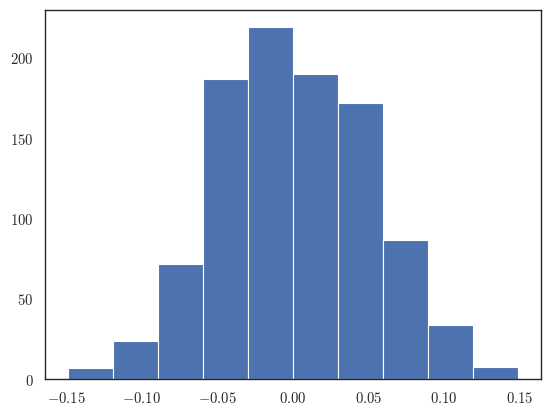

In [19]:
plt.hist(syn['estimate'].to_numpy())

(array([ 57., 116.,  43., 164., 128.,  98., 158.,  47., 124.,  65.]),
 array([-0.3925422 , -0.31449211, -0.23644203, -0.15839194, -0.08034186,
        -0.00229177,  0.07575831,  0.15380839,  0.23185848,  0.30990856,
         0.38795865]),
 <BarContainer object of 10 artists>)

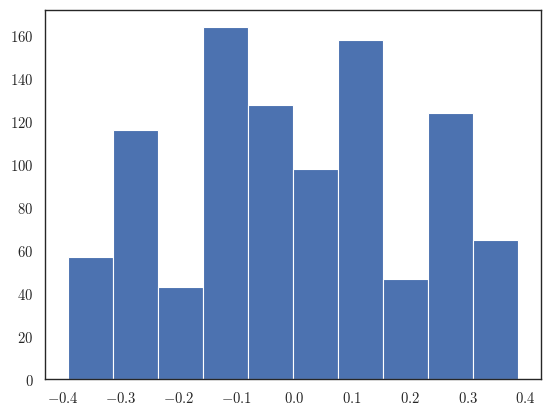

In [20]:
plt.hist(rec['estimate'].to_numpy())